In [2]:
from functions import *
import matplotlib.pyplot as plt
import scipy.optimize as op
from scipy.integrate import odeint
import camb
from camb import model, initialpower

In [3]:
#%% fitting to obtain numerical solution for recomb rate
#initial guess
a_guess = np.array([2e-13, 0.8])
#initialise values for recomb coefficient
z = np.linspace(700, 1700, 2000)
a_data = a_ex(z)

fit_a, cov_a = op.curve_fit(exp_fit, z, a_data, a_guess)

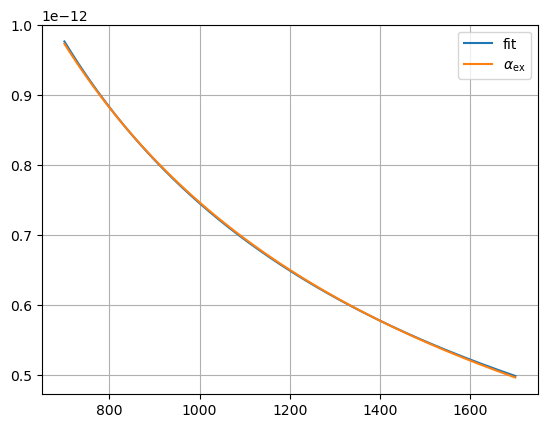

In [16]:
#alpha ex fit check

plt.plot(z, exp_fit(z, fit_a[0], fit_a[1]), label='fit')
plt.plot(z, a_data, label='$\\alpha_{\mathrm{ex}}$')
plt.legend()
plt.grid()
plt.show()

In [4]:
# C check
def inverse_ratio(z, X):
    return Lambda*K(z)*(1-X)*ng(z)*eta

def C(z,X):
    C1 = 1+inverse_ratio(z, X)
    C2 = 1+inverse_ratio(z, X)*(Lambda+b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1]))
    return C1/C2
#print(C(1000,0))

In [5]:
#get camb parameters
pars=camb.CAMBparams()
pars.set_cosmology(70)
pars.InitPower.set_params(2e-9,0.965,0)
pars.set_for_lmax(2000)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit = 'muK')
pars = camb.set_params(H0=67.3, ombh2=0.02207, omch2=0.1198, As=2e-9, ns=0.95)
data= camb.get_background(pars)

In [6]:
#contour map of C x = redshift y = ionisation fraction
x = np.linspace(600, 1400, 1000)
y = np.linspace(0, 1, 1000)
xx,yy = np.meshgrid(x,y)
cc = C(xx,yy)
rr = inverse_ratio(xx, yy)
back_ev = data.get_background_redshift_evolution(x, ['x_e', 'visibility'], format='array')
cmb = back_ev[:,0]

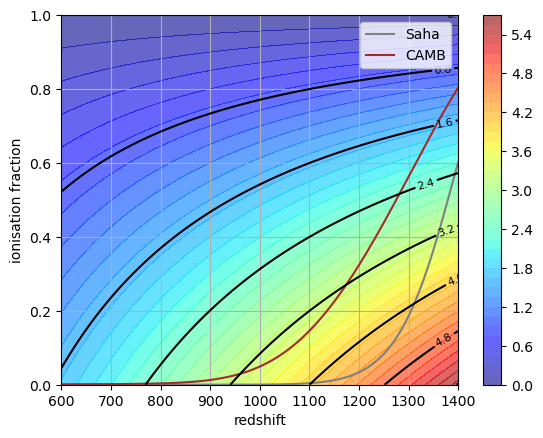

In [7]:
contour = plt.contourf(xx, yy, rr, 40, cmap='jet', alpha=0.6)
plt.plot(x, saha(x), color='grey', label='Saha')
plt.plot(x, cmb, label='CAMB', color='brown')
cont = plt.contour(xx,yy, rr, 8, colors='black')
plt.clabel(cont, inline=True, fontsize=8)
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.grid()
plt.colorbar(contour)
plt.legend()
plt.show()
#we see that ratio goes from 0->3 as expected

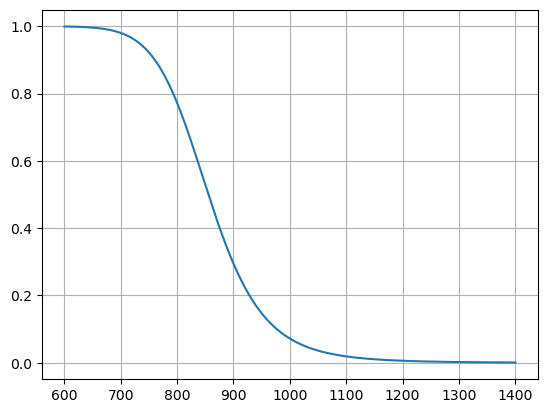

In [8]:
#estimating C using lambda/(lambda+beta)
estimate = 1/(1+b_over_a(x)*exp_fit(x, fit_a[0], fit_a[1])/Lambda)
plt.plot(x, estimate)
plt.grid()
plt.show()
#C gets bigger and actually tends to 1 which is for beta/lambda <<1
#for this approximations to be good, would need ratio to be bigger than something like 3 as we have here

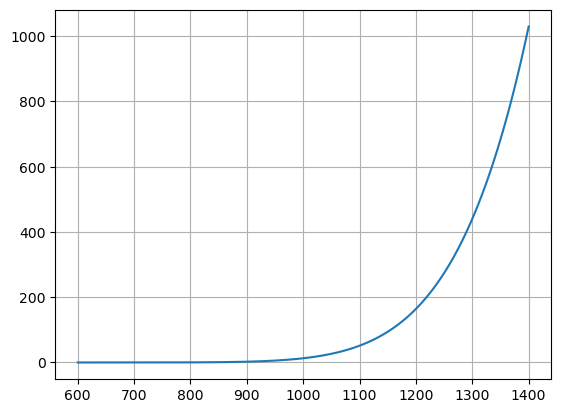

In [43]:
#beta/lambda
bl = b_over_a(x)*exp_fit(x, fit_a[0], fit_a[1])/Lambda
plt.plot(x, bl)
plt.grid()
plt.show()

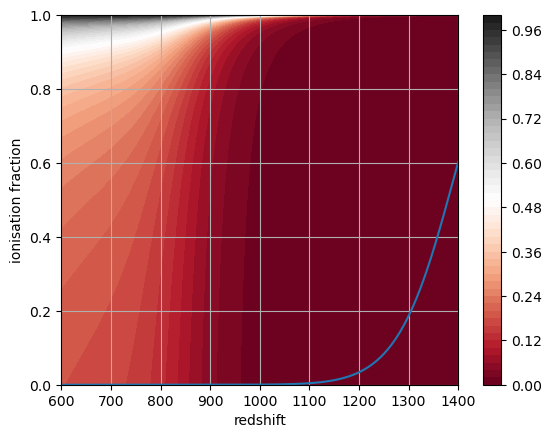

In [47]:
plt.contourf(xx, yy, cc, 50, cmap='RdGy')
plt.plot(x, saha(x))
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.grid()
plt.colorbar()
plt.savefig('Images/C map.png', dpi=300)
plt.show()

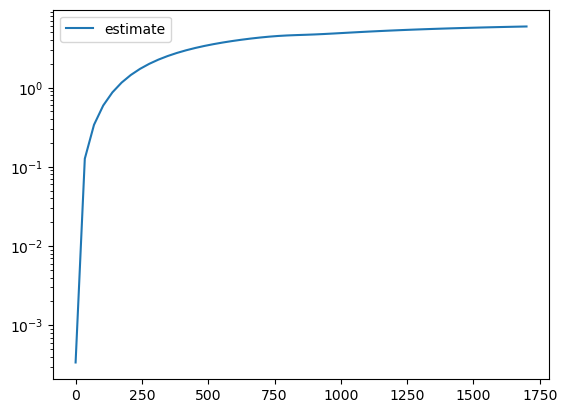

In [65]:
#checking C for X = 0.3 similar to conditions at z = 1200
x = np.linspace(0, 1700)
C1200 = C(x, 0.3)
#plt.plot(x, C1200,label='real')
plt.plot(x, (1/(1+b_over_a(x)*exp_fit(x, fit_a[0], fit_a[1])/Lambda) - C1200)/C1200, label='estimate')
plt.legend()
plt.yscale('log')
plt.show()

In [20]:
#checking photon density and hubble param
Hu = Hubble(x)
n_g = ng(x)

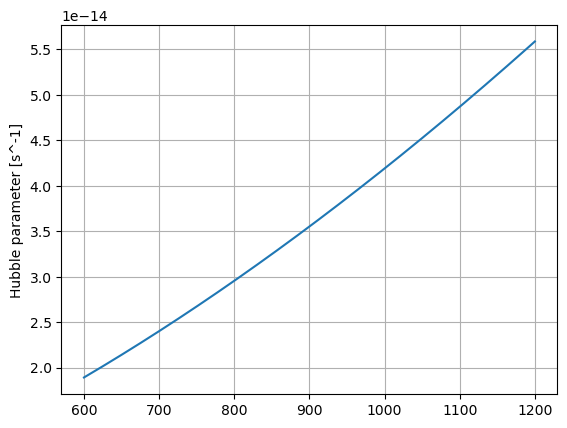

In [21]:
plt.plot(x, Hu)
plt.ylabel('Hubble parameter [s^-1]')
plt.grid()
plt.show()

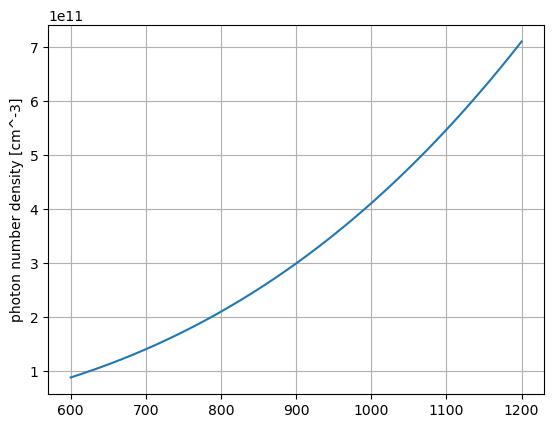

In [22]:
plt.plot(x, n_g)
plt.ylabel('photon number density [cm^-3]')
plt.grid()
plt.show()

In [23]:
#rate of recomb v rate of photoionisation
def rate_a(z, X):
    return exp_fit(z, fit_a[0], fit_a[1])*X*X*eta*ng(z)
def rate_b(z, X):
    return b_over_a(z)*exp_fit(z, fit_a[0], fit_a[1])*np.exp(-ly/Temp(z))*(1-X)

In [24]:
xnew = np.linspace(800, 1400, 1000)
ynew = np.linspace(0, 1, 1000)
X,Y = np.meshgrid(xnew, ynew)
a = rate_a(X, Y)
b = rate_b(X, Y)

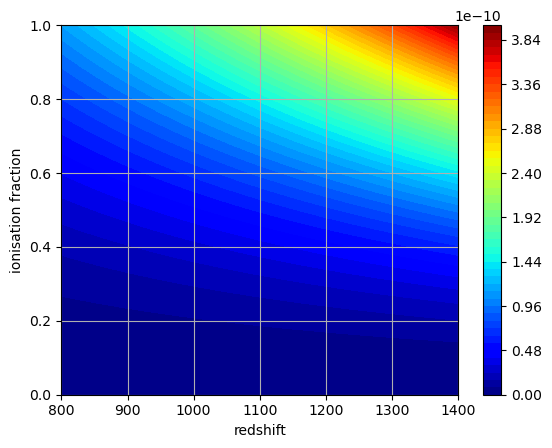

In [25]:
plt.contourf(X, Y, a, 50, cmap='jet')
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.grid()
plt.colorbar()
plt.show()

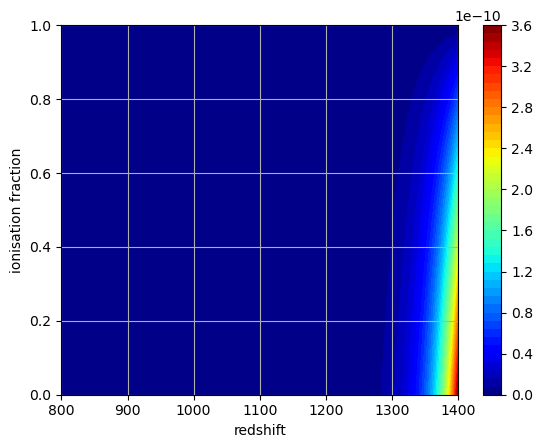

In [26]:
plt.contourf(X, Y, b, 50, cmap='jet')
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.grid()
plt.colorbar()
plt.show()

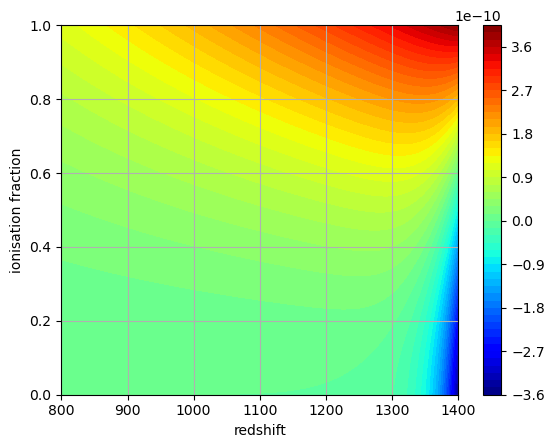

In [27]:
delta = a-b
plt.contourf(X, Y, delta, 50, cmap='jet')
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.grid()
plt.colorbar()
plt.show()

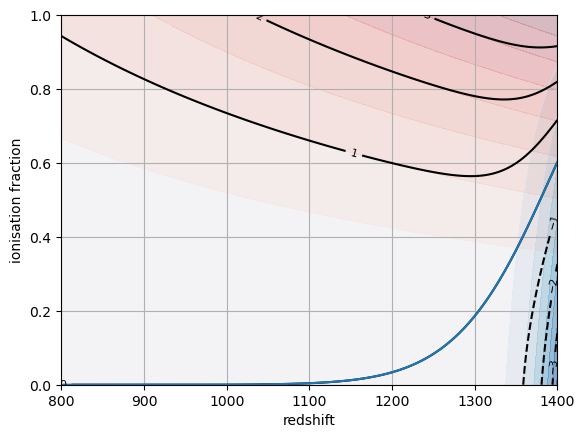

In [28]:
plt.contourf(X, Y, a, cmap='Reds',alpha=0.5)
plt.contourf(X, Y, b, cmap='Blues',alpha=0.5)
cont = plt.contour(X,Y, delta, 8, colors='black')
plt.plot(xnew, saha(xnew))
plt.clabel(cont, inline=True, fontsize=8)
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.savefig('Images/a-b.png', dpi=300)
plt.grid()

In [29]:
testz = 1000
testX = 5e-4

print(rate_a(testz, testX)-rate_b(testz, testX))
print(rate_a(testz,testX))

2.768068948515476e-17
4.629483638527413e-17


In [30]:
#function for differential equation of X
def X_diff(z, X):
    prefactor = 1/((1+z)*Hubble(z))
    return prefactor*(rate_a(z, X))*C(z, X)

In [31]:
diff_a = X_diff(X, Y)

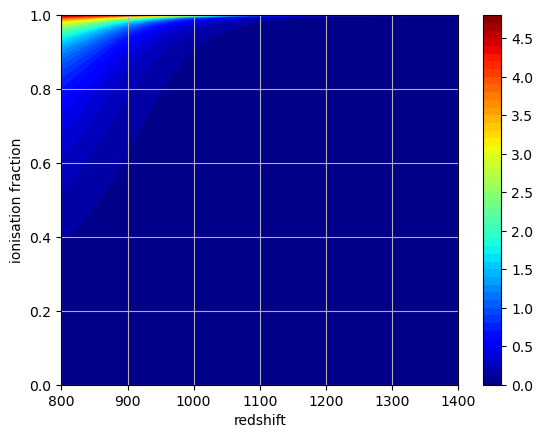

In [32]:
plt.contourf(X, Y, diff_a, 50, cmap='jet')
plt.xlabel('redshift')
plt.ylabel('ionisation fraction')
plt.grid()
plt.colorbar()
plt.show()

In [33]:
print(X_diff(800, 1))

4.749996220015131


In [34]:
#numerical integration of dX/dz
t = np.linspace(1700.0, 800.0, 1000)
sol_X = odeint(X_diff, 1, t, tfirst=True)
X = sol_X[:,0]

In [35]:
print(X)

[1.         0.99654198 0.99508943 0.99396505 0.99300969 0.99216181
 0.99138989 0.99067522 0.99000564 0.9893727  0.98877027 0.98819372
 0.98763946 0.98710463 0.98658692 0.98608444 0.98559559 0.98511904
 0.98465362 0.98419837 0.98375242 0.98331501 0.98288549 0.98246326
 0.98204781 0.98163866 0.98123539 0.98083761 0.98044498 0.98005719
 0.97967394 0.97929498 0.97892004 0.97854892 0.9781814  0.97781729
 0.9774564  0.97709858 0.97674367 0.97639152 0.976042   0.97569498
 0.97535034 0.97500796 0.97466774 0.97432958 0.97399339 0.97365907
 0.97332654 0.97299571 0.97266652 0.97233888 0.97201273 0.97168801
 0.97136464 0.97104257 0.97072174 0.97040209 0.97008358 0.96976615
 0.96944975 0.96913433 0.96881986 0.96850628 0.96819355 0.96788165
 0.96757051 0.96726012 0.96695043 0.96664141 0.96633302 0.96602523
 0.96571801 0.96541133 0.96510517 0.96479948 0.96449425 0.96418944
 0.96388503 0.963581   0.96327732 0.96297397 0.96267092 0.96236814
 0.96206563 0.96176335 0.96146129 0.96115941 0.96085772 0.9605

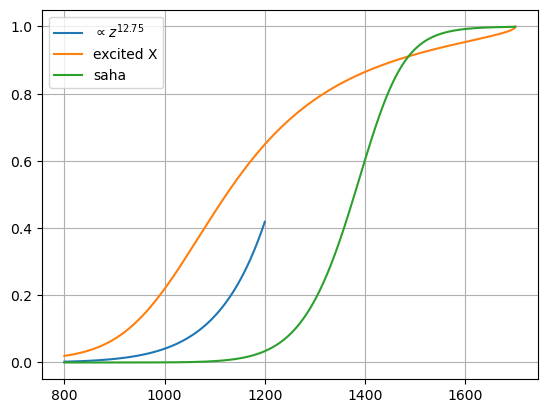

In [36]:
trunc = np.linspace(800, 1200, 100)
review_fit = rev_ex(trunc)
plt.plot(trunc, review_fit, label='$\propto z^{12.75}$')
plt.plot(t, X, label='excited X')
plt.plot(t, saha(t), label='saha')
plt.grid()
plt.legend()
plt.show()